In [54]:
import os
import numpy as np
import pandas as pd
from dfply import *
import seaborn as sns
import matplotlib
from matplotlib import gridspec
import matplotlib.dates as md
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# 환경설정
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
if not any([s=='result' for s in os.listdir()]): os.mkdir('result')

In [3]:
# 데이터 불러오기
weather = pd.read_csv('data/weather_v1.csv', low_memory=False, dtype={
    'area': str,
    'temp_QCFlag': str,
    'prec_QCFlag': str,
    'ws_QCFlag': str,
    'wd_QCFlag': str,
    'humid_QCFlag': str,
    'landP_QCFlag': str,
    'seaP_QCFlag': str,
    'suntime_QCFlag': str,
    'sfctemp_QCFlag': str,
})
target = pd.read_csv('data/target_v1.csv')
target['date'] = pd.to_datetime(target['date'])
target = target[['date', 'supply']]

In [4]:
# 기온 일별 집계 및 전력수급실적 병합
daily_temp_jeju_supply = weather \
    >> mask(X.area == '184') \
    >> mask(~X.temp.isna()) \
    >> mutate(date=X.datetime.str.slice(0,10)) \
    >> group_by(X.date) \
    >> summarise(temp_mean=X.temp.mean())
daily_temp_jeju_supply['date'] = pd.to_datetime(daily_temp_jeju_supply['date'])
daily_temp_jeju_supply = daily_temp_jeju_supply.merge(target, on='date', how='outer')

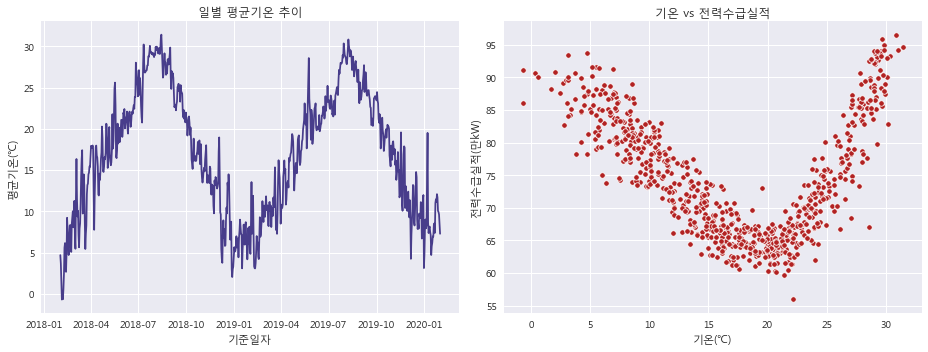

In [191]:
# 시각화
fig, ax = plt.subplots(1,2, figsize=(13,5))

sns.lineplot(x='date', y='temp_mean', data=daily_temp_jeju_supply, ax=ax[0], color='darkslateblue')
ax[0].set_xlabel('기준일자')
ax[0].set_ylabel('평균기온(℃)')
ax[0].set_title('일별 평균기온 추이')

sns.scatterplot(x='temp_mean', y='supply', data=daily_temp_jeju_supply, s=30, color='firebrick', ax=ax[1])
ax[1].set_xlabel('기온(℃)')
ax[1].set_ylabel('전력수급실적(만kW)')
ax[1].set_title('기온 vs 전력수급실적')

plt.tight_layout()
plt.show()

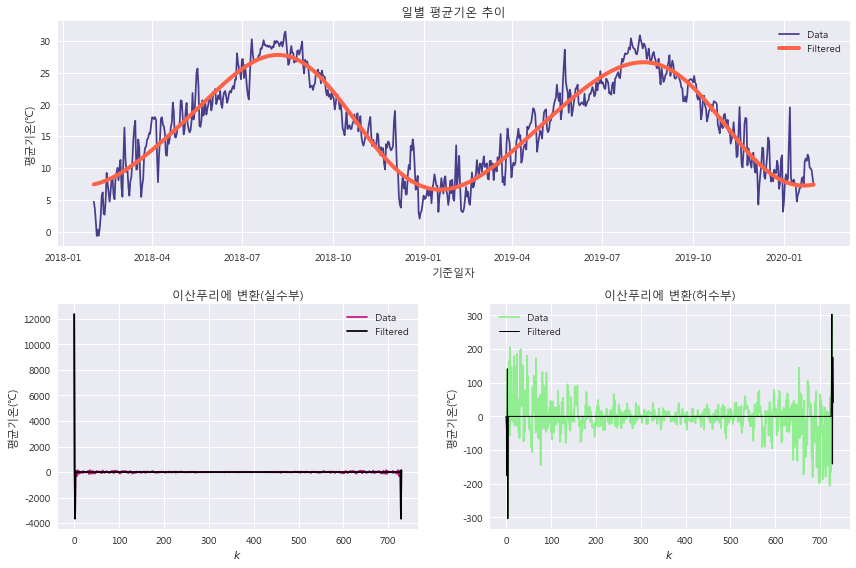

In [155]:
# 이산푸리에 변환 및 필터링
fig = plt.figure(figsize=(12,8))

gs = gridspec.GridSpec(2,1)
gs0 = gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=gs[0])
gs1 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gs[1])

ax0 = fig.add_subplot(gs0[0])
ax10 = fig.add_subplot(gs1[0])
ax11 = fig.add_subplot(gs1[1])

freq = np.fft.fft(daily_temp_jeju_supply['temp_mean'])

sns.lineplot(x='date', y='temp_mean', data=daily_temp_jeju_supply, ax=ax0, color='darkslateblue', label='Data')
ax0.set_xlabel('기준일자')
ax0.set_ylabel('평균기온(℃)')
ax0.set_title('일별 평균기온 추이')

################## Filtering ##################
M = 5
N = len(daily_temp_jeju_supply)
freq_filtered = freq.copy()
freq_filtered[M:-M] = 0
omega = np.array([2*np.pi/N*i for i in range(N)])
fn_temp_filtered = lambda t: (1/N)*(np.sum(-freq_filtered.imag*np.sin(omega*t)+freq_filtered.real*np.cos(omega*t)))
temp_filtered = np.array([fn_temp_filtered(t) for t in range(N)])
ax0.plot(daily_temp_jeju_supply['date'], temp_filtered, color='tomato', lw=4, label='Filtered')
ax0.legend()
###############################################

ax10.plot(freq.real, color='mediumvioletred', label='Data')
ax10.plot(freq_filtered.real, color='k', label='Filtered')
ax10.set_title('이산푸리에 변환(실수부)')
ax10.set_ylabel('평균기온(℃)')
ax10.set_xlabel('$k$')
ax10.legend()

ax11.plot(freq.imag, color='lightgreen', label='Data')
ax11.plot(freq_filtered.imag, color='k', label='Filtered')
ax11.set_title('이산푸리에 변환(허수부)')
ax11.set_ylabel('평균기온(℃)')
ax11.set_xlabel('$k$')
ax11.legend()

plt.tight_layout()
plt.show()

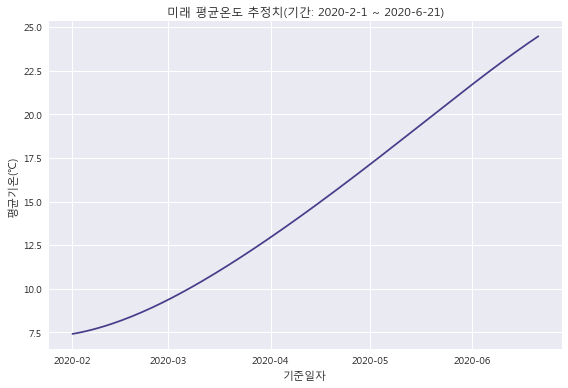

In [202]:
# 미래 평균온도 추정
target_dates = pd.date_range('2020-2-1', '2020-6-21')
temp_predict = np.array([fn_temp_filtered(t) for t in range(N, N+len(target_dates))])
daily_temp_jeju_predict = pd.DataFrame(temp_predict, index=target_dates)
daily_temp_jeju_predict = daily_temp_jeju_predict.reset_index()
daily_temp_jeju_predict.columns=['date', 'temp_mean_predict']

fig = plt.figure()
sns.lineplot(x='date', y='temp_mean_predict', data=daily_temp_jeju_predict, color='darkslateblue')
plt.ylabel('평균기온(℃)')
plt.xlabel('기준일자')
plt.title('미래 평균온도 추정치(기간: 2020-2-1 ~ 2020-6-21)')
plt.tight_layout()
plt.show()

In [205]:
# 엑셀 출력
now = datetime.now().strftime('%Y%m%d%H%M%S')
with pd.ExcelWriter('result/temp_mean_predict_{}.xlsx'.format(now), 'xlsxwriter') as writer:
    daily_temp_jeju_predict.to_excel(writer, index=False)